# Solution to Taxi-V2 with Q-learning

## The task

As defined in `gym`:

> There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

### Markov Decission Process for Taxi-v2

States:
- Grid world of 5x5 with walls
- Passenger position: Red, Green, Yellow and Blue (or in the taxi)
- Destinations: Red, Green, Yellow and Blue
Total amount of states: 5*5*5*4 = 500 discrete states

Actions: North, South, West, East, Pick Up, Drop Off

Rewards: 
- Each time step: -1
- Succesfully drop the passenger: 20
- Illegal Pick up or drop off: -10

In [12]:
from agent import Agent
from monitor import interact
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import gym
import numpy as np
import sys
import math

## The Agent

The agent is passed to the environment monitor and we will iterate through every step of the episodes. The Agent receives some extra information for each step it does while only receive the state when choosing the next action.

In [56]:
class QLearningAgent:

    def __init__(self, nA=6, epsilon=1.0, alpha=.05, gamma=1.0):
        """ Initialize agent.
        
        Params
        ======
        - nA: number of actions available to the agent
        - epsilon: parameter for epsilon-Greedy algorithm
        - alpha: "Learning rate"
        - gamma: Discount factor
        """
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma


    def __update_Q(self, current_Q, next_Q, reward):
        """ Updates the action-value function estimate using the most recent time step """
        return current_Q + (self.alpha * (reward + (self.gamma * next_Q) - current_Q))

    def select_action(self, state):
        """ Given the state, select an action """
        policy_probabilities = np.ones(self.nA) * self.epsilon / self.nA
        policy_probabilities[np.argmax(self.Q[state])] = 1 - self.epsilon + (self.epsilon / self.nA)

        return np.random.choice(np.arange(self.nA), p=policy_probabilities)

    def step(self, state, action, reward, next_state, episode, done):
        """ Update the agent's knowledge, using the most recently sampled tuple """
        self.epsilon = 1.0 / episode
        
        self.Q[state][action] = self.__update_Q(self.Q[state][action], np.max(self.Q[next_state]), reward)      

Going a bit more in detail we are using the Q-learning algorithm:
<img src="./q-learning-algorithm.png" alt="drawing" width="600"/>


In this exercise I will explore a bit how different gamma/epsilon/alpha affect the learning curve.

In [24]:
def interact(env, agent, num_episodes=20000, window=100):
    """ Monitor agents performance
    
    Params
    ======
    - env: instance of OpenAI Gym's Taxi-v1 environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - avg_rewards: deque containing average rewards
    - best_avg_reward: largest value in the avg_rewards deque
    """
    avg_rewards = deque(maxlen=num_episodes)
    best_avg_reward = -math.inf
    samp_rewards = deque(maxlen=window)
    convergence_episode = 0
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        samp_reward = 0
        
        # Steps in episode
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, i_episode, done)
            
            # update the sampled reward
            samp_reward += reward

            state = next_state
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= window):
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            avg_rewards.append(avg_reward)

            if avg_reward > best_avg_reward:
                convergence_episode = i_episode
                best_avg_reward = avg_reward

        print("\rEpisode {}/{} || Best average reward {}".format(i_episode, num_episodes, best_avg_reward), end="")
        sys.stdout.flush()
        
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
    return avg_rewards, best_avg_reward, convergence_episode

Episode 20000/20000 || Best average reward 8.6544

Best avg. for alpha = 0.01 : 8.65. Reached on episode: 19212
Episode 20000/20000 || Best average reward 8.627

Best avg. for alpha = 0.05 : 8.62. Reached on episode: 6644
Episode 20000/20000 || Best average reward 8.787

Best avg. for alpha = 0.1 : 8.78. Reached on episode: 19244
Episode 20000/20000 || Best average reward 8.844

Best avg. for alpha = 0.15 : 8.84. Reached on episode: 13413
Episode 20000/20000 || Best average reward 8.829

Best avg. for alpha = 0.2 : 8.82. Reached on episode: 10042


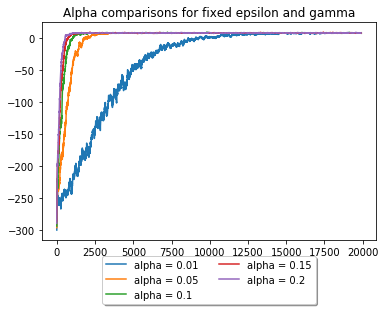

In [25]:
env = gym.make('Taxi-v3')

alpha_variations = [.01, .05, .1, .15, .2 ]

fig = plt.figure()
ax = plt.subplot(111)
plt.title("Alpha comparisons for fixed epsilon and gamma")
for alpha in alpha_variations:
    agent = QLearningAgent(alpha=alpha)
    avg_rewards, best_avg_reward, episode_best_reward = interact(env, agent)
    
    print(f'Best avg. for alpha = {alpha} : {best_avg_reward}. Reached on episode: {episode_best_reward}')
    ax.plot(list(range(len(avg_rewards))), avg_rewards, label=f'alpha = {alpha}')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

We can observe how for low values of alpha the convergence happens slower and as it grows it closer to the step function on 0.

Smaller values for α encourage the agent to consider a longer history of returns when calculating the action-value function estimate. Increasing the value of α ensures that the agent focuses more on the most recently sampled returns. 

Episode 20000/20000 || Best average reward 8.668

Best avg. for epsilon = 1.0 : 8.66. Reached on episode: 12211
Episode 20000/20000 || Best average reward 8.999

Best avg. for epsilon = 0.9 : 8.9. Reached on episode: 5021
Episode 20000/20000 || Best average reward 8.827

Best avg. for epsilon = 0.95 : 8.82. Reached on episode: 10725
Episode 20000/20000 || Best average reward 8.735

Best avg. for epsilon = 0.8 : 8.73. Reached on episode: 7599
Episode 20000/20000 || Best average reward 8.783

Best avg. for epsilon = 0.2 : 8.78. Reached on episode: 7478


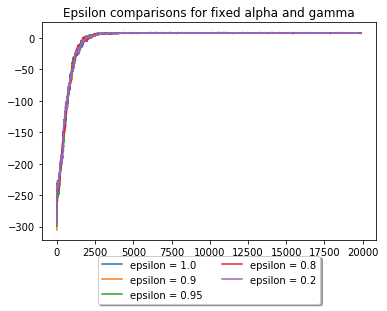

In [28]:
epsilon_variations = [1.0, .9, .95, .8, 0.2 ]

fig = plt.figure()
ax = plt.subplot(111)
plt.title("Epsilon comparisons for fixed alpha and gamma")
for epsilon in epsilon_variations:
    agent = QLearningAgent(epsilon=epsilon)
    avg_rewards, best_avg_reward, episode_best_reward = interact(env, agent)
    
    print(f'Best avg. for epsilon = {epsilon} : {best_avg_reward}. Reached on episode: {episode_best_reward}')
    ax.plot(list(range(len(avg_rewards))), avg_rewards, label=f'epsilon = {epsilon}')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

Episode 20000/20000 || Best average reward 8.717

Best avg. for gamma = 1.0 : 8.71. Reached on episode: 17162
Episode 20000/20000 || Best average reward 8.754

Best avg. for gamma = 0.9 : 8.75. Reached on episode: 10599
Episode 20000/20000 || Best average reward 8.723

Best avg. for gamma = 0.8 : 8.72. Reached on episode: 17108
Episode 20000/20000 || Best average reward 8.667

Best avg. for gamma = 0.7 : 8.66. Reached on episode: 15126
Episode 20000/20000 || Best average reward 8.2128

Best avg. for gamma = 0.2 : 8.21. Reached on episode: 19850


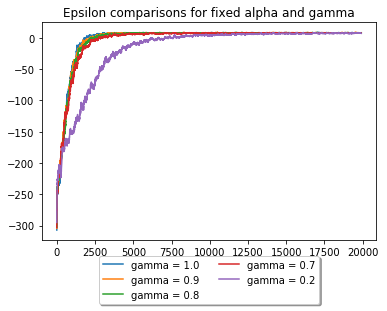

In [27]:
gamma_variations = [1.0, .9, .8, .7, .2 ]

fig = plt.figure()
ax = plt.subplot(111)
plt.title("Epsilon comparisons for fixed alpha and gamma")
for gamma in gamma_variations:
    agent = QLearningAgent(gamma=gamma)
    avg_rewards, best_avg_reward, episode_best_reward = interact(env, agent)
    
    print(f'Best avg. for gamma = {gamma} : {best_avg_reward}. Reached on episode: {episode_best_reward}')
    ax.plot(list(range(len(avg_rewards))), avg_rewards, label=f'gamma = {gamma}')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

We can see how lower gamma (discounted reward) promotes sort term vision when changing the value, basically the changes of future rewards will be lower hence our agent will learn slower. For some task this maybe useful, but in the case of Taxi-v3 we need to consider further future rewards.

So with the hyper parameters:
- epsilon: 0.9
- gamma: 0.9
- alpha: 0.04

We will run and analyse the resulted Q matrix

In [37]:
agent = QLearningAgent(gamma=.9, alpha=.04, epsilon=0.9)
avg_rewards, best_avg_reward, episode_best_reward = interact(env, agent)

Episode 20000/20000 || Best average reward 8.987



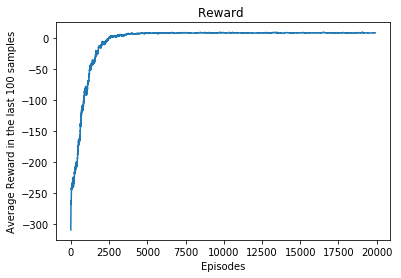

In [40]:
fig = plt.figure()
ax = plt.subplot(111)
plt.title("Reward ")
ax.plot(list(range(len(avg_rewards))), avg_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward in the last 100 samples')
plt.show()

In [62]:
state = env.reset()
steps = 0
env.render()        
# Steps in episode
while True:
    steps = steps + 1
    action = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    # update the sampled reward
    state = next_state
    env.render()
    if done:
        break
print(steps)        
        

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
7


Since we have 500 discrete states it becomes a bit difficult to visualize all the policies, but... given the best reward of ~=9, and knowing that the reward when the mission is acomplished is 20, we can estimate that our agent can solve this puzzle in an average of 12 steps. 

<img src="./taxi-simulation.png" alt="drawing" width="800"/>